# Data processing

In this notebook, I am loading a list of molecules I obtained from Reference Librairy (shared in slack) and processing them to make sure I have:
- Standard SMILES representation of the compound
- InChIKey associated to the compound

In [15]:
# In this codeblock I will import the necessary packages and specify the paths to relevant folders

# importing packages

import rdkit
import pathlib
import chemprop
import numpy as np
import pandas as pd
from rdkit import Chem
import sys 
import ersilia
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

#giving necessary paths
sys.path.append('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/src')
import smiles_processing


In [3]:
# Appplying some settings to pandas for clear representation of data
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth', 30)

In [4]:
# In this codeblock I will load the data from the /data folder to a Pandas dataframe and understand which headers it has# In this codeblock I will load the data from the /data folder to a Pandas dataframe and understand which headers it has
df = pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/reference_library.csv')
print(df.head())

                          smiles
0   CCCCNC(=S)N/N=C/C1=C(C)C=CS1
1  CN1C(SCC2=NC(C3=CC=CS3)=NO...
2  O=C(O)CC(NC(=O)C1=CN=CC=N1...
3  O=S(=O)(C1=CC=CC=C1)N1CCN(...
4  CCC[C@@H](C)N(C1=CC(Cl)=CC...


In [8]:
# In this codeblock I will convert the molecules to standard SMILES by using the function standardise_smiles from /src
# I will import the function directly from src, not copying it here

# making a list of smiles

smiles_list=df['smiles'].tolist()

#standardising the smiles

import smiles_processing
from smiles_processing import standardise_smiles

standard_smiles_list=standardise_smiles(smiles_list)

In [221]:
# In this codeblock I will get the Inchikey representation of the molecules using the RDKIT package

#making the list of inchikeys

mol_list = [Chem.MolFromSmiles(smiles) for smiles in standard_smiles_list]
InChIKey_list = [Chem.MolToInchiKey(mol) for mol in mol_list]


In [222]:
# In this codeblock I will save the data as a .csv file containing only the standard smiles and the inchikey as columns. 
# All data will be saved with informative names in the /data folder

#creating the dataframe with standard smiles and inchikeys
df = pd.DataFrame({'standard smiles': standard_smiles_list})
df['inchikey'] = InChIKey_list
print(df.head(5))

#making the csv file which contains the 1000 molecules on which predictions will be amde by the eos4tcc model
df.to_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/1000_values_dataset.csv',index=False)


                 standard smiles                     inchikey
0       CCCCNC(=S)N/N=C/c1sccc1C  SUTWUYBMBWPLMW-MDWZMJQESA-N
1  Cn1c(SCc2nc(-c3cccs3)no2)n...  RIYHJWOTNJXDLV-UHFFFAOYSA-N
2  O=C(O)CC(NC(=O)c1cnccn1)c1...  OGNBARHGQVMGGX-UHFFFAOYSA-N
3  O=S(=O)(c1ccccc1)N1CCN(c2n...  WQEXDIRUOYNDCM-UHFFFAOYSA-N
4  CCC[C@@H](C)N(c1cc(Cl)ccc1...  YEGVLLQDOGYWDQ-OAHLLOKOSA-N


# Model Bias Evaluation

Now, I will use the predictions I got from the Ersilia Model Hub on the dataset of 1000 molecules curated above and see how are they distributed in their space (which might be 0 to 1 for probabilities, or different for regression models)

In [3]:
# In this codeblock I will load the predictions I've run on Ersilia and saved in the /data folder

predictions=pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/output.csv')
print(predictions.head(5))

                           key  \
0  SUTWUYBMBWPLMW-MDWZMJQESA-N   
1  RIYHJWOTNJXDLV-UHFFFAOYSA-N   
2  OGNBARHGQVMGGX-UHFFFAOYSA-N   
3  WQEXDIRUOYNDCM-UHFFFAOYSA-N   
4  YEGVLLQDOGYWDQ-OAHLLOKOSA-N   

                                               input     score      alea  \
0                           CCCCNC(=S)N/N=C/c1sccc1C  0.424873  0.237075   
1              Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1  0.420451  0.239160   
2                 O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl  0.423009  0.237702   
3       O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1  0.430128  0.238675   
4  CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1  0.434911  0.239533   

       epis  
0  0.007281  
1  0.004512  
2  0.006370  
3  0.006443  
4  0.006230  


## Understanding of the model 💭

The model takes 1000 smiles as input from the dataset "1000_values_dataset.csv". It generates inchikey and gives the following three outputs:
1. score: This is the hERG channel inhibition percentage at 10µm. BayeshERG is a graph neural network (GNN)-based Bayesian DL model. It calculates the hERG blocking probability using the softmax function. If the score is ≥ 0.5, the molecule is calssified as a hERG blocker and if the score is < 0.5 it is considered to be a non-hERG blocker. This score helps us to perform classification labelling the blackers as 1 and non-blockers as 0
2. alea: This refers to the "aleatoric" uncertainity which is referred to as the model uncertainity due to the lack of data.
3. epis: This refers to the "epistemic" uncertainity which is referred to as the model uncertainity due to data’s intrinsic randomness which may be caused due to noise inherent in the dataset.

Comment on uncertainity : The uncertainity or VARIANCE is the sum total of quantified epistemic and aleatoric uncertainty.

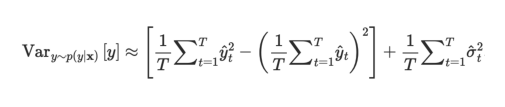

In [33]:
#variance formula
image = plt.imread('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/images/Readme_figures/variance_formual.png')
plt.figure(figsize=(3, 1),dpi=200)
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
#modifying the dataframe to depict the uncertainity associated with the observations
#NOTE: Variance is a property I have added for analyis, it is not the output of the model, the model has only three outputs 'score','alea' and 'epis'

predictions['variance']=predictions['alea']+predictions['epis']
print(predictions.head(5))

                           key  \
0  SUTWUYBMBWPLMW-MDWZMJQESA-N   
1  RIYHJWOTNJXDLV-UHFFFAOYSA-N   
2  OGNBARHGQVMGGX-UHFFFAOYSA-N   
3  WQEXDIRUOYNDCM-UHFFFAOYSA-N   
4  YEGVLLQDOGYWDQ-OAHLLOKOSA-N   

                                               input     score      alea  \
0                           CCCCNC(=S)N/N=C/c1sccc1C  0.424873  0.237075   
1              Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1  0.420451  0.239160   
2                 O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl  0.423009  0.237702   
3       O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1  0.430128  0.238675   
4  CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1  0.434911  0.239533   

       epis  variance  
0  0.007281  0.244356  
1  0.004512  0.243672  
2  0.006370  0.244072  
3  0.006443  0.245118  
4  0.006230  0.245763  


## Data Processing ⚙️

In [6]:
#checking if any row has null value to clean the data

rows_with_nan = predictions.isnull().any(axis=1)
print(predictions[rows_with_nan])

Empty DataFrame
Columns: [key, input, score, alea, epis, variance]
Index: []


## Observations' Section 📝

In [16]:
# All the figures in this section will be saved in results_references folder present in the images folder
folder_location = "/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/images/results_reference_librairy"

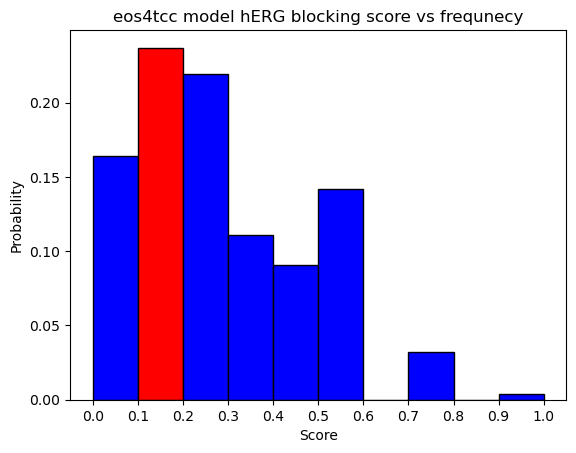

In [17]:
# In this codeblock I will create the necessary plots with MatPlotLib to observe the distribution of predicted values

# Plot between the hERG blocking activity of molecules and their frequency
b = np.arange(0.0, 1.1, 0.1)
score=predictions['score'].to_list()
weights = np.ones_like(score) / float(len(score))
plt.hist(score, bins=b, edgecolor='black',weights=weights,color='blue')
max_probability_bin = plt.gca().patches[max(range(len(plt.gca().patches)), key=lambda i: plt.gca().patches[i].get_height())]
max_probability_bin.set_facecolor('red')
plt.title('eos4tcc model hERG blocking score vs frequnecy')
plt.xlabel('Score')
ticks=np.arange(0.0,1.1,0.1)
plt.xticks(ticks)
plt.ylabel('Probability')
plt.savefig(folder_location + "/plot1.png")
plt.show()



#### Inference from the histogram
1. Most of the molecules (about 25%) have hERG blocking activity score in the range (0.1-0.2)
2. Molecules with very strong hERG blocking activity i.e. hERG blocking activity score > 0.95 are just approximately 0.5%.
3. Unexpected result: I did not expect that there will be molecules in the score range (0.6-0.7) and (0.8-0.9) but suprisingly that's the case!

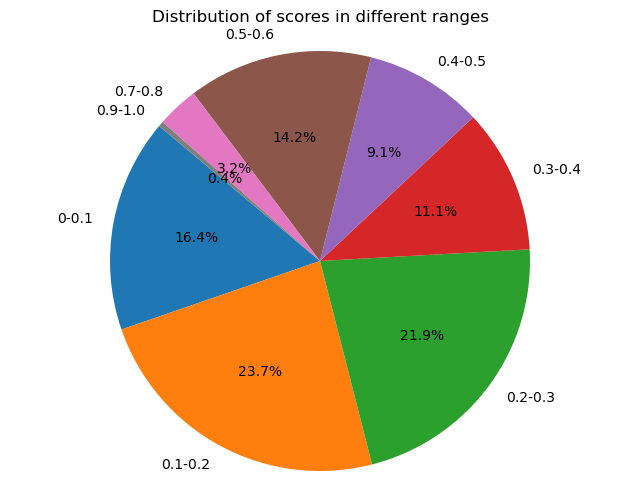

In [18]:
# showing the percentage of each interval of hERG blocking activity

ranges = [(0, 0.1), (0.1, 0.2), (0.2,0.3), (0.3,0.4), (0.4,0.5), (0.5,0.6), (0.6,0.7), (0.7,0.8), (0.8,0.9), (0.9,1.0)]
categories = []
for value in predictions['score']:
    for r in ranges:
        if r[0] <= value < r[1]:
            categories.append(r)
            break
counts = pd.Series(categories).value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=[f'{r[0]}-{r[1]}' for r in counts.index], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of scores in different ranges')
plt.axis('equal')
plt.savefig(folder_location + "/plot2.png")
plt.show()

### Inferences from the pie chart 
1. We can see that more than 50 percent of the molecules have hERG blocking activity score less than 0.4 which means that they are non-blockers.
2. This data is very well in agreement with any random dataset that we come across in real life where the number of non-hERG blockers dominates the number of hERG blockers
3. Let's go ahead and make this visualisation even better!

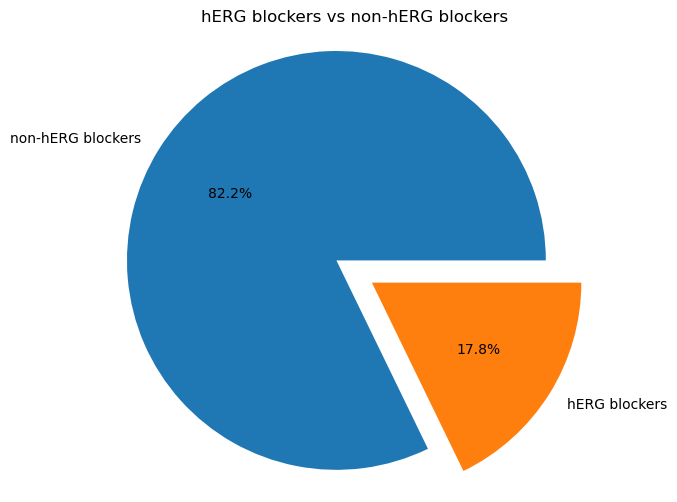

In [22]:
ranges = [(0, 0.5), (0.5,1.0)]
categories = []
for value in predictions['score']:
    for r in ranges:
        if r[0] <= value < r[1]:
            categories.append(r)
            break
counts = pd.Series(categories).value_counts().sort_index()
plt.figure(figsize=(8, 6))
labels=['non-hERG blockers','hERG blockers']
explode=(0.1,0.1)
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=0,explode=explode)
plt.title('hERG blockers vs non-hERG blockers')
plt.axis('equal')
plt.savefig(folder_location + "/plot3.png")
plt.show()

### Let's dive into uncertainities ! 💡

As discussed before, aleatoric uncertainity arises from inherent randomness of the data and this component of uncertainity can't be reduced even by gathering more information. On the other hand , epistemic unceratinity arises due to lack of information and therefore can be reduced by gathering more information. In this section, I would like to analyse the data for aleatoric and epistemic unceratinities to know if the model is lagging due to lack of information.

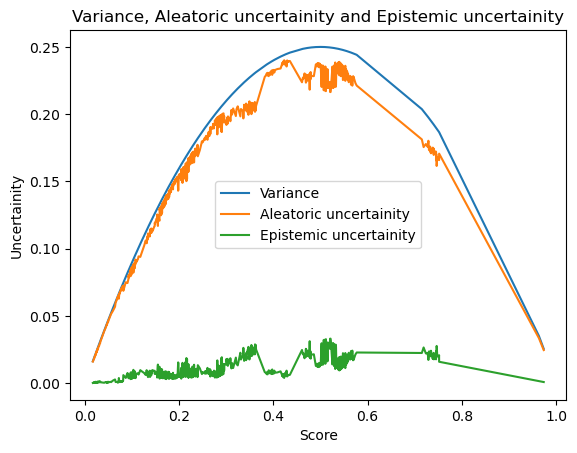

In [20]:
# sorting the dataframe accoring to the score values to make inferences about uncertainity

sorted_df=predictions.sort_values(by='score')

#making the line graphs here

plt.title('Variance, Aleatoric uncertainity and Epistemic uncertainity')
plt.xlabel('Score')
plt.ylabel('Uncertainity')
plt.plot(sorted_df.score,sorted_df.variance,label='Variance')
plt.plot(sorted_df.score,sorted_df.alea,label='Aleatoric uncertainity')
plt.plot(sorted_df.score,sorted_df.epis,label='Epistemic uncertainity')
plt.legend()
plt.savefig(folder_location + "/plot4.png")
plt.show()

### Inference from the line graphs 

1. From the above graph, we can see that the maximum uncertainity arises when we are in the zone of hERG blocking activity score values between 0.4 to 0.6 which means the predictions are least trused when they are made for molecules lying in this range.
2. Scope of improvement: we can see from the above graph that although the variance/uncertainity is quite high for the range 0.4-0.6, most of it comes from the aleatoric component which is the non-reducible part of uncertainity as discussed before. Only a very small portion of uncertainity comes from the epistemic part (reducible part) but this portion is quite insignificant when looking at the total variance/uncertainity.
3. Thus, the model performs very well and most of the uncertainity it faces is due to the inherent randomness present in data which cannot be ruled out.
4. If improvements have to be made, they should be made for molecules in the score range 0.4-0.8 where the epistemic component forms maximum percentage of total variance. This can be done by collecting more data for this range. Since our main culprit is the epistemic component ,let's further analyse this component using scatter plots!

### Scatter Plot - Veryfying our observations for aleatoric uncertainity !

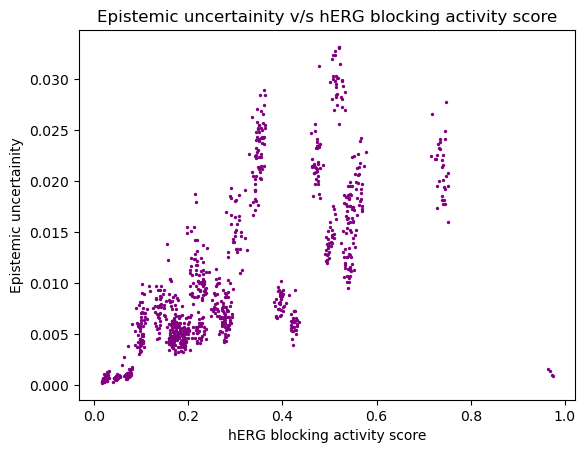

In [21]:
x = sorted_df['score'].to_list()
y = sorted_df['epis'].to_list()
plt.title('Epistemic uncertainity v/s hERG blocking activity score')
plt.xlabel('hERG blocking activity score')
plt.ylabel('Epistemic uncertainity')
plt.scatter(x, y, color = 'purple',s=2)
plt.savefig(folder_location + "/plot5.png")
plt.show()

### Inferences from scatter plot

1. Clearly we can see that we have a lot of data points in the range 0.0-0.4 and here the aleatoric uncertainity is very less. 
2. However, as we move to the 0.4-0.8 score range, the number of data points decreases and the aleatoric uncertainity increases due to lack of data.
3. For the 0.8-1.0 range, very few molecules are present so solid conclusions can't be made!